# Part 3: Practice

This is the last part of IIC tutorial. Here we try to use for clustering and semi-supervised classification of MNIST.
Some useful functions are implemented in utils.py Feel free to look there if you want to understand how the work in detail.

If you a working in Google colab you need to do  a coouple of additional moves. First, go to "Runtime" menu, click on "Cnage runtme type", and select GPU option in "Runtime type
Hardware accelerator" menu. After this run the cell below. After the execution is finished, restart the runtime.

In [44]:
!wger https://raw.githubusercontent.com/vandedok/IIC_tutorial/master/requirements.txt --output requirements.txt
!curl https://raw.githubusercontent.com/vandedok/IIC_tutorial/master/tutorial/utils.py --output utils.py
!curl https://raw.githubusercontent.com/vandedok/IIC_tutorial/master/tutorial/preprocess.py --output preprocess.py
!pip install -r requirements.txt

/bin/bash: wger: command not found
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8796  100  8796    0     0  76486      0 --:--:-- --:--:-- --:--:-- 76486
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5887  100  5887    0     0  55018      0 --:--:-- --:--:-- --:--:-- 55018


Imports

In [2]:
import random
import os
import sys
from tqdm.notebook import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category=UserWarning)
import numpy as np
import torch
from torch import nn
import albumentations as A
import torchvision.models as models

from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.metrics.cluster import homogeneity_score, completeness_score

from utils import  visualize_augmentations, weight_init, print_while_trainig, get_cluster_labeling, visualise_clusetering_results, stratified_split
from utils import create_mapping, print_mapping
from preprocess import create_MNIST_dataset_with_preprocessed_augs

In [3]:
#This  will enable automatic downloading of MNIST
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [4]:
#Fix torch randomization for reproducability
torch.manual_seed(42)

## Preprocessing the data

First of all we define the augmentations, which are on of the keys to IIC approach. I use Albumentations library to compose horizontal flips, rotations, perspective changes, superpixels, noise, brightness and contrast transforms. Each of theses transforms can be applied with a certain probability to input image.

In [5]:
alb_transforms= A.Compose([
    A.HorizontalFlip(),
    A.Rotate(limit=40, p=0.7),
    A.IAAPerspective(scale=(0.1, 0.1), p=0.7),
    A.IAASuperpixels(p_replace=0.3, p=0.7),
    A.IAAAdditiveGaussianNoise(scale = ( 0.1 * 255 , 0.2 * 255 ), p=0.7),
    A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.6, p=0.7)
])

Now we need to define a dataset

We can do it in a usual way, by inheriting MNIST dataset class and editing the transforms call in ```__getitem__``` method like [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). However this approach has a huge drawback -- at each call a new augmentation is computed, so during the training a lot of time is spent not for the forward and backward runs, but to get an augmented batch. To avoid this, we precompute the augmentations in advance  and save them as np files. 

I implemented this approach in the ```preprocessing``` module. The function ```create_MNIST_dataset_with_preprocessed_augs```  downloads MNIST to ```DATASET_DIR```, saves the images and the data as np files, computes the augmentations and then saves the augmented images in np files. It's possible to choose a number of augmentations (default is 10) -- the same number of np files will created, each of them containin a dataset augmented only one time.

<span style="font-size:larger;">WARNING: this line can take several minutes to run.</span>

In [6]:
AUG_NUMBER = 10
DATASET_DIR = "dataset"
# create_MNIST_dataset_with_preprocessed_augs(alb_transforms, target_dir=DATASET_DIR, batch_size=256, aug_number=AUG_NUMBER, num_workers=4)

If you want to see, how  it is implemented, feel free to look at function code and docstrings in [preprocessing module](link_to_preprocessing_module). However for this tutorial it's sufficient to know, that at this stage several np files are created in the ```DATASET_DIR```: one containing the original MNIST, one containing the labels and several others of them containing the augmented versions of MNIST

Now we create a new dataset class. It is storing original MNIST and it's augmentaions in RAM. When the  ```__getitem__``` method is called, it returns the original image, the label and the randomly chosen augmentation.

In [7]:
class NumpyAugDataset(Dataset):
    """The dataset contatining the original and augmented data in RAM 
    
    Attributes
    ----------
    original_numpy_file : str
        path to .np file with original dataset
    aug_numpy_files : list of str
        list of paths to the .np files with augmented dataset versions
    labels_file : str
        path to a .np file with labels
    original_dataset : numpy.ndarray
        numpy array with original dataset 
    aug_datasets : list of numpy.ndarray
        list of numpy arrays with augmented datasets
    aug_number : int
        number of augmentations
    labels: numpy.ndarray
        numpy array with labels
        
    """
    def __init__(self, original_numpy_file, aug_numpy_files, labels_file):
        """ Datasetataset initialisation
            
        Parameters
        ----------
        original_numpy_file : str
            path to .np file with original dataset
        aug_numpy_files : list of str
            list of paths to the .np files with augmented dataset versions
        labels_file : str
            path to a .np file with labels
        original_dataset : numpy.ndarray
        """
        self.original_numpy_file = original_numpy_file
        self.aug_numpy_files = aug_numpy_files
        self.labels_file = labels_file
        self.original_dataset = np.load(original_numpy_file)
        self.aug_datasets= [
            np.load(file) for file in aug_numpy_files
        ]
        self.aug_number = len(self.aug_numpy_files)
        self.labels = np.load(labels_file)
        
    def __len__(self):
        """returns the length of the dataset"""
        return(self.original_dataset.shape[0] )
        
    def __getitem__(self, idx):
        """Returns the dataset sample and index idx
        
        Returns
        -------
        return_dict : dict
            dict with the following keys:
            "original" : numpy.ndarray
                original image taken from self.original_dataset 
            "aug" : numpy.ndarray
                augmented image taken randomly from one of self.aug_datasets
            "label" : int
                run label of the image taken form self.labels
        """
        aug_version = int(self.aug_number * random.random())
        return_dict = {
            "original": self.original_dataset[idx:idx+1,:,:],
            "aug": self.aug_datasets[aug_version][idx:idx+1,:,:],
            "label": self.labels[idx]
        }
        return return_dict

In [8]:
original_mnist_np_file = os.path.join(DATASET_DIR, "mnist_original.np")
aug_mnist_np_files = [os.path.join(DATASET_DIR, "mnist_aug_" + str(i) + ".np") for i in range(AUG_NUMBER)]
labels_mnist_np_file = os.path.join(DATASET_DIR, "mnist_labels.np")

dataset_np = NumpyAugDataset(
    original_mnist_np_file,
    aug_mnist_np_files,
    labels_mnist_np_file
)



Now we perform the stratified train-val split of the dataset. This is needed for semi-supervised classification setting. The validation part will be small -- only 600 images. We assume, that the train part has no labels so we are are not going to use them. Stratification is needed to make sure that each class is represented equally in the test part.

In [9]:
dataset_train, dataset_val = stratified_split(dataset_np, train_size=0.99)

Define the dataloaders:

In [10]:
BATCH_SIZE = 2048
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=16)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=16)

It's useful to see how our augmentations look. It can be done with the ```visualize_augmentations``` from ```utils.py```. Each run will fetch random augmentations.

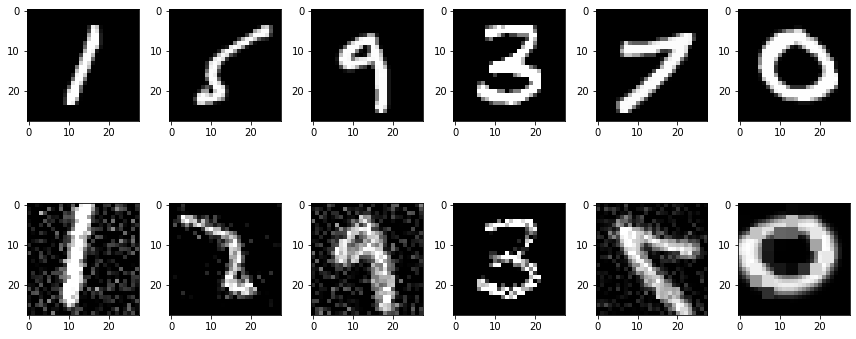

In [11]:
visualize_augmentations(dataset_val, samples=6)

Great! We successfully  preprocessed the data and ready to build a model.

## The model

It's time to define a clustering model based on resnet backbone. This is a really basic CV model with the only unusual part being the presence of two fully connected layers: clustering_head and overclustering_head. The latter one is needed to improve the learning process (see <a href="https://arxiv.org/abs/1807.06653">original paper</a>  or appendix in [Part 1](https://github.com/vandedok/IIC_tutorial/blob/master/tutorial/part_1.ipynb) of this tutorial).

Let's define a ResNet backbone, based, say, on  ResNat18 model. In IIC approach we don't expect the model to have any prior knowledge, so we set "pretrained" parameter to False.

In [12]:
resnet = models.resnet18(pretrained=False)

First we want to get bare CNN backbone. This means, that we need to cut a couple of layers from the top of the model. To see, which ones we need to cut, lest print several last layers:

In [13]:
print(list(resnet.children())[-3:])

[Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=

The layers to cut are AdaptiveAvgPool2d and Linear:

In [14]:
modules_to_keep = list(resnet.children())[:-2]

The original ResNet18 model is designed to process to color images. We can adapt it to grayscale images by modifying the first layer:

In [15]:
print("The first layer:", modules_to_keep[0])

The first layer: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


All we need to do is to redefine this module with the same parameters except for the ```in_channels```:

In [16]:
modules_to_keep[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Now let's append Flatten layer and compose a backbone to see how many output features it has.

In [17]:
modules_to_keep.append(nn.Flatten())
backbone = nn.Sequential(*modules_to_keep)

To see the number of output features we define a batch of images. To speed up the computation we leave only tree images in our batch:

In [18]:
batch = next(iter(dataloader_train))['original']
batch = batch[0:3]
print("Batch shape:", batch.shape)

Batch shape: torch.Size([3, 1, 28, 28])


It's time to see how many features our backbone outputs:

In [19]:
print("Output shape:", backbone(batch).shape)

Output shape: torch.Size([3, 512])


It has 512 features. We will use it to define clustering and overclustering heads:

In [20]:
final_features = 512
cluster_head = nn.Linear(final_features, 10)
overcluster_head = nn.Linear(final_features, 50)

Now let's gather everything in an ```nn.Module```:

In [21]:
class ResNetClusterisator(nn.Module):
    """Clusterisator for IIC based on ResNet18 backbone"""
    
    def __init__(self):
        super(ResNetClusterisator, self).__init__()
        # The number of output features we precomputed earlier
        final_features = 512
        
        #Define the backbone:
        resnet = models.resnet18(pretrained=False)
        modules = list(resnet.children())[:-2]
        modules[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        modules.append(nn.Flatten())
        self.backbone = nn.Sequential(*modules)
        
        #Define clustering and overculstering heads
        self.cluster_head = nn.Linear(final_features, 10)
        self.overcluster_head = nn.Linear(final_features, 50)
        
        #Define the softmax layer
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, overclustering=False):
        '''Foward run. Can operate in both clustering an overclustering regimes
        
        Paraneters
        ----------
        x : torch.tensor
            input batch. The shape is supposed to be (B,1,28,28)
            where B is batch size
        overclustering : boolean
            if True, the overclustering head is used
            else the clustering head is used
        '''
        x = self.backbone(x)
        if overclustering:
            x = self.overcluster_head(x)
        else:
            x = self.cluster_head(x)
            
        return self.softmax(x)

Now let's transfer our model to gpu and initialise the weights. Note, that in general different initialisations can result in signifcatnly different performance

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using %s."%device)
model = ResNetClusterisator()
model.to(device)
print("The model is transfered to %s."%device)
model.apply(weight_init)
print("The weights are Initialised.")

Using cuda.
The model is transfered to cuda.
The weights are Initialised.


Let's check that everything is fine by making a forward run:

In [23]:
batch = next(iter(dataloader_train))['original']
batch = batch.to(device)
print("Model output shape in clustering mode:", model(batch).shape)
print("Model output shape in overclustering mode:", model(batch).shape)

Model output shape in clustering mode: torch.Size([2048, 10])
Model output shape in overclustering mode: torch.Size([2048, 10])


Fine! Let's proceed to the loss function.

## Mutual information loss

The second ingredient of IIC is a mutual information loss function. This code is based on the [original paper implementation](https://github.com/xu-ji/IIC/blob/master/code/utils/cluster/IID_losses.py#L6) with a minor changes. The mathematical details of  mutual information loss can be found in [Part 2](https://github.com/vandedok/IIC_tutorial/blob/master/tutorial/part_2.ipynb) of this tutorial.

First we compute the estimation of the joint probability distribution

In [24]:
def compute_joint(x_out, x_tf_out):
    ''' Estimate a joint probability distribution
    
    Parameters
    ----------
    x_out : torch.tensor
        shape (B,C) where B is a batch size, C is a number of classes
        probabilities for the original batch
    x_out_tf: torch.tensor
        the same shape as x_out
        probabilities for the trasformed batch
    
    Returns
    -------
    p_i_j : torch.tensor
        shape (C,C) where C is a number of classes (the same as in x_out)
        joint probabilities
    
    '''       
    # multiplying probabilities
    p_i_j = x_out.unsqueeze(2) * x_tf_out.unsqueeze(1)  # bn, k, k
    
    # suminng over the batch_size
    p_i_j = p_i_j.mean(dim=0)
    
    # Symmetriztion
    p_i_j = (p_i_j + p_i_j.t()) / 2.

    return p_i_j

And than the mutual information. There is a couple of tricks used here. 

The first one is the regularization of joint probabilities. Recall, that what we compute mutual information we take the log of joints. When some joint probabilities $p_{ij}$ are small, $\log p_{ij}$ may be too large to be stored in float, so the NaN value will be returned. To avoid this we take a small value $\epsilon$ and replace with it all the joints which are less than $\epsilon$:

$$\forall p_{ij} < \epsilon: \log(p_{ij}) ~~\mathrm{is~replaced~with}~~ \log(\epsilon)$$

Mathematically this correct, as those logarithms comes only in expressions as $p_{ij}\log(p_{ij})$, which goes еo zero as $p_{ij}$ goes to zero.

The second one is the additional minus sign on in front of the mutual information. As we applied it, we need to minimize, not to maximize our loss.

In [25]:
def IID_loss(x_out, x_tf_out, lamb=1.0, EPS=sys.float_info.epsilon):
    ''' Compute mutual information loss. Theo overall minus sign is added so the loss should be minimized. 
    
    Parameters
    ----------
    x_out : torch.tensor
        shape (B,C) where B is a batch size, C is a number of classes
        probabilities for the original batch
    x_out_tf: torch.tensor
        the same shape as x_out
        probabilities for the trasformed batch
    lambd : float
        parameter modyfing the loss. 
        Larger lamb generally pushes the model towards putting
        spreading the samples to the different clusters of equal sizes. 
        Smaller lambd pushes the model towards putting similar images to one cluster
    EPS : float
        parameter to regulerize small probabilities 
        
    
    Returns
    -------
    loss : torch.tensor
        shape (1,). Mutual information loss
    
    '''       
    _, num_classes = x_out.size()
    
    # Estimate joint probabilities
    p_i_j = compute_joint(x_out, x_tf_out)
    assert (p_i_j.size() == (num_classes, num_classes))
    
    # Trick to avoid NaN losses for small p_i_j
    mask = ((p_i_j > EPS).data).type(torch.float32)
    p_i_j = p_i_j * mask + EPS * (1 - mask)
    
    # Computing the marginals
    p_i = p_i_j.sum(dim=1).view(num_classes, 1).expand(num_classes, num_classes)
    p_j = p_i_j.sum(dim=0).view(1, num_classes).expand(num_classes,num_classes)  # but should be same, symmetric

    #Compute the mutual information
    loss =  - p_i_j * (torch.log(p_i_j) \
                    - lamb * torch.log(p_j) \
                    - lamb * torch.log(p_i))

    loss = torch.sum(loss)

    return loss

Thats all about the loss implemetation. Now let's go to the traning!

## Training

Let's take a look at IIC forward run. Our train dataloader will give us batch with original images, transfomed images and labels:

In [26]:
batch = next(iter(dataloader_train))
print("Batch entities:", batch.keys(), end="\n\n")
print("Original images batch shape:     {0}".format(batch['original'].shape))
print("Transformed images batch shape:  {0}".format(batch['aug'].shape))
print("Labels batch shape:              {0}".format(batch['label'].shape))


Batch entities: dict_keys(['original', 'aug', 'label'])

Original images batch shape:     torch.Size([2048, 1, 28, 28])
Transformed images batch shape:  torch.Size([2048, 1, 28, 28])
Labels batch shape:              torch.Size([2048])


We are not using labels in training. 

We begin the forward run with nullifying the gradients:

Than we transfer batches to the gpu:

In [27]:
inputs = batch["original"]
inputs_tf = batch["aug"]

inputs = inputs.to(device=device)
inputs_tf = inputs_tf.to(device=device)

The last thing to do is to compute the outputs, the loss and make a backward run:

In [28]:
overclustering = False
lamb = 1.0
outputs = model(inputs, overclustering)
outputs_tf = model(inputs_tf, overclustering)
loss = IID_loss(outputs, outputs_tf, lamb = lamb)
print(loss.data.cpu().numpy())
loss.backward()

-0.0009901393


That's it! 

Before rushing into training we need a funtion to evaluate the loss. It just iterates over dataloader, makes the forward run and computes  the mean loss:

In [29]:
def evaluate(model,dataloader, overclustering=False, lamb = 1., device=torch.device("cpu")):
    '''Calculates the model mean loss. The average is taken over the batches.
    '''

    losses = []
    #switch model to the eval state to prevent the training
    model.eval()
    
    for i, batch in enumerate(dataloader):
            
            #forward run
            inputs = batch["original"]
            inputs_tf = batch["aug"]
            with torch.no_grad():   
                              
                inputs = inputs.to(device=device)
                inputs_tf = inputs_tf.to(device=device)
                
                outputs = model(inputs, overclustering)
                outputs_tf = model(inputs_tf, overclustering)
                                  
            loss = IID_loss(outputs, outputs_tf, lamb = lamb)
            
            #combining the losses for all batches into a single list
            losses.append(loss.data.cpu().numpy())
            
    #output the mean loss
    return np.mean(losses)

Recall, that in [Part 1](https://github.com/vandedok/IIC_tutorial/blob/master/tutorial/part_1.ipynb) we discussed, that our model can greatly benefit from switching between clustering and overculstering. Here we implement it in a following way:

In [30]:
def choose_clustering_regime(epoch, overcluster_period, overcluster_ratio):
    '''Choice of the clustering regimy based on the epoch number
    
    Parameters
    ----------
    epoch : int
        current epoch number    
    overcluster_period : int
        total period for both clustering and overclustering
    overcluster_ratio : float
        a fraction of time to spend on overclustering
    '''
    
    if overcluster_period is not None and epoch % overcluster_period < overcluster_period * overcluster_ratio:
        return True
    else:
        return False

Now it's time to combine the forward run and the backward run in a training loop. I have also put some printing stuff here, so you can observe loss evolution during the training.  

In [31]:
def IIC_train(
    modeldataset, 
    dataloader, 
    optimizer, 
    epochs = 100, 
    device = torch.device("cpu"), 
    eval_every = 5,
    lamb = 1., 
    overcluster_period = 20, 
    overcluster_ratio = 0.5 
):
    '''IIC training loop
    
    Parameters
    ----------
    model : ResNetClusterisator
        the IIC model to train
    dataloader : torch.utils.data.dataloader.DataLoader
        dataloader to fetch the data
    optimizer : torch.optim.optimier like
        your favourite optimzer
    epochs : int
        total number of epoches 
    device : torch.device
        device which sould perform the trainig
    eval_every : int
        the freqency of evaluation
    lamb : float
        paramter to modyfy IID_loss (see IID_loss)
    overcluster_period : int
        total period for both clustering and overclustering
    overcluster_ratio : float
        a fraction of time to spend on overclustering 
    '''
    
    
    #Lists to store epochs numbers and losses for visualisation
    epochs_list = []
    loss_history = []
    loss_history_overclustering = []
    
    #Variables for best losses
    best_cluster_loss = 0
    best_overcluster_loss = 0

    #Progress bar instance
    pbar = tqdm(total=len(dataloader), leave=False, desc="Epoch")
    
    for epoch in range(epochs):
        
        # Switching the model to train mode
        model.train()
        # Define where the epoch is dedicated to clustering or overclustering
        overclustering = choose_clustering_regime(epoch, overcluster_period, overcluster_ratio)
        
        #Reseting the progress bar 
        pbar.reset()
        pbar.desc = "Epoch #%i"%epoch 
        
        for i, batch in enumerate(dataloader):
                
            #Nullifing the gradients    
            optimizer.zero_grad()
            
            #Forward run
            inputs = batch["original"]
            inputs_tf = batch["aug"]

            inputs = inputs.to(device=device)
            inputs_tf = inputs_tf.to(device=device)

            outputs = model(inputs, overclustering)
            outputs_tf = model(inputs_tf, overclustering)
            loss = IID_loss(outputs, outputs_tf, lamb = lamb)
            
            #Backward run
            loss.backward()
            
            #Updating the weights
            optimizer.step()
            
            #Updating the progreess bar
            pbar.update(1)

        #Evaluation section
        if (epoch+1) % eval_every == 0:  

            #Computing eval losses
            loss_eval = evaluate(model, dataloader, overclustering=False, lamb=lamb, device=device)
            loss_eval_overclustering = evaluate(model, dataloader, overclustering=True, lamb = lamb, device=device)

            loss_history.append(loss_eval)
            loss_history_overclustering.append(loss_eval_overclustering)
            epochs_list.append(epoch)

            #Saving the model with best evaluation loss
            if loss_eval < best_cluster_loss:
                best_cluster_loss = loss_eval
                torch.save(model.state_dict(), "best_loss_model")

            pbar.close() 
            
            #Visualising the training
            print_while_trainig(epochs_list, loss_history, loss_history_overclustering)
            
            pbar = tqdm(total=len(dataloader), leave=False, desc = "Epoch")


Let's begin the training

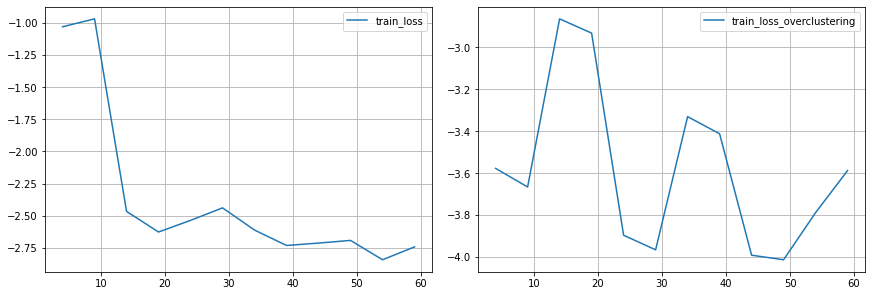

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=4e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
IIC_train(model, dataloader_train,  optimizer, device=device, epochs=60, lamb=1.2, overcluster_period=20, overcluster_ratio=0.5)

You should see a non-monotonously decaying line. When the model in the clustering mode, overclusetring loss can grow and vice versa. However after about 70 epochs the clustering loss reaches plateau and the training can be stopped.

## Evaluation

It's time to evaluate our models performance. Firstly we load the model which showed the best loss on train data: 

### Clustering

In [33]:
model.load_state_dict(torch.load("best_loss_model"))

<All keys matched successfully>

Than we compose two labelings -- the original one and the one which is outputted by the model. Note, that in a fair clustering setting the original labels are not available, so this method is applicable only in testing _clustering method_ on a labeled dataset. 

In [34]:
original_labels, cluster_labels = get_cluster_labeling(model, dataloader_train, device=device)

We visualize the results with a set of histograms. Each histograms corresponds to a certain original class and shows, how  clustering labels are distributed along this class. The best case is when all the histograms have a single huge bin. 

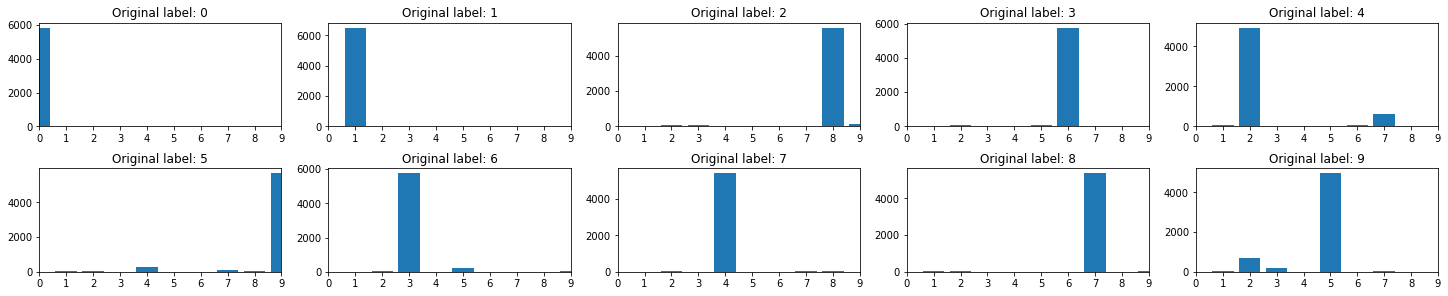

In [35]:
visualise_clusetering_results(original_labels, cluster_labels)

We can also compute some clustering scores to get a numerical metrics of the clustering. Here I use [adjusted_rand_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html), [homogeneity_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html), [completeness_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html). The closer the values to ones, the better:

In [36]:
adj_score = adjusted_rand_score(cluster_labels, original_labels)
hom_score = homogeneity_score(cluster_labels, original_labels)
compl_score = completeness_score(cluster_labels, original_labels)
print("Adjusted rand score: %.3f "%adj_score )
print("Homogeneity score: %.3f "%adj_score )
print("Completeness score: %.3f"%compl_score)

Adjusted rand score: 0.875 
Homogeneity score: 0.875 
Completeness score: 0.879


### Semi-supervised classification

To evaluate the model in semi-supervised classification setting, we use our val dataloader, which fetches the data previously unseen by the model

In [37]:
original_labels, cluster_labels = get_cluster_labeling(model, dataloader_val, device=device)

We visualize the labels in the same way as before:

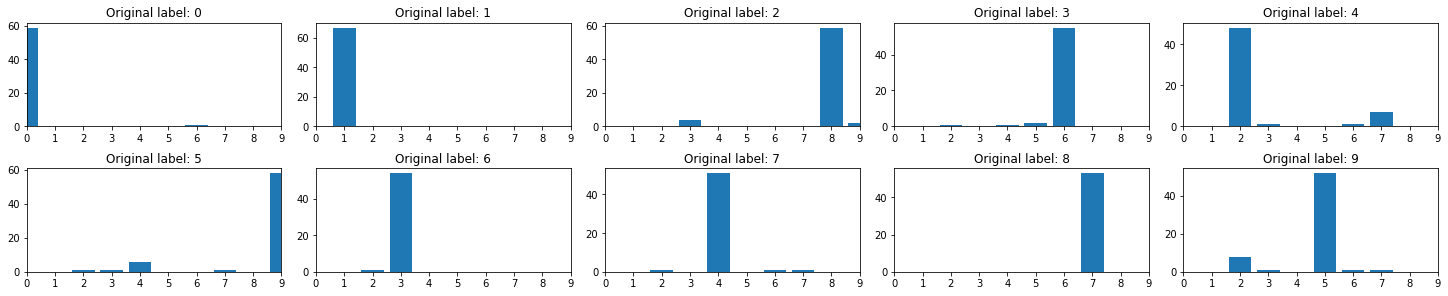

In [38]:
visualise_clusetering_results(original_labels, cluster_labels)

To compute usual classification metrics, we need to create a mapping from cluster labels to original labels. Function ```create_mapping``` does it by assigning the most frequent class present in the cluster:

In [39]:
cluster_mapping = create_mapping(original_labels, cluster_labels)
cluster_labels_mapped = [cluster_mapping[x] for x in cluster_labels]

The mapping is:

In [40]:
print_mapping(cluster_mapping)

Cluster  Class
  0 -----> 0
  1 -----> 1
  2 -----> 8
  3 -----> 6
  4 -----> 2
  5 -----> 9
  6 -----> 3
  7 -----> 4
  8 -----> 7
  9 -----> 5


Now the bins should be at the places which correspond to the original labels:

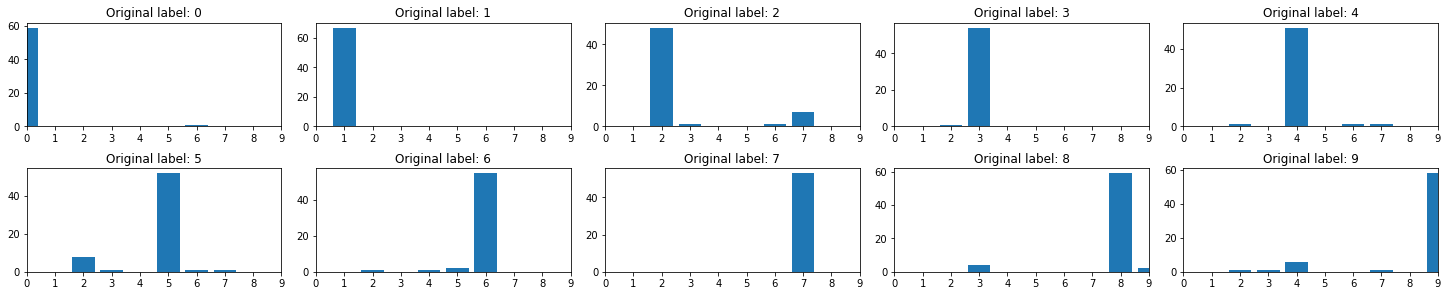

In [41]:
visualise_clusetering_results(original_labels, cluster_labels_mapped)

The accuracy is:

In [42]:
accuracy_score(original_labels, cluster_labels_mapped)

0.9266666666666666

If the training was done correctly the accuracy should be grater than 0.9. The autors of the <a href="https://arxiv.org/abs/1807.06653">original paper</a> achieved the accuracy of 99.2%

## Conclusion

If everything went well, by this line you have successfully trained and evaluated IIC model. Congrats!